In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator, EMAIndicator

In [2]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [13]:
def load_and_prepare_data():
    stock_data = pd.read_csv('final_data.csv')
    sentiment_data = pd.read_csv('daily-avg-sentiment-scores.csv')

    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])

    stock_data = stock_data.rename(columns={'Date': 'date'})
    
    merged_data = pd.merge(stock_data, sentiment_data[['date', 'sentiment_score_final']], 
                          on='date', how='inner')
    
    merged_data = merged_data.sort_values('date').reset_index(drop=True)
    
    return merged_data

In [5]:
def prepare_sequences(data, sequence_length=10):
    features = ['Close', 'Open', 'High', 'Low', 'Volume', 'sentiment_score_final',
                'daily_return', 'log_return', 'SMA_short', 'SMA_long', 'EMA_short', 'EMA_long',
                'volatility', 'ATR', 'RSI', 'MACD', 'bollinger_h', 'bollinger_l',
                'momentum', 'ROC', 'Day_of_week', 'Month', 'Quarter',
                'lagged_return', 'lagged_close', 'volume_change', 'volume_sma',
                'price_to_sma', 'high_low_range']
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[features])
    
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length, 0])
    
    return np.array(X), np.array(y), scaler, features

In [6]:
def plot_results(train_losses, val_losses, predictions, actuals, train_size):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(actuals, label='Actual', alpha=0.7)
    plt.plot(range(train_size), predictions[:train_size], label='Train Predictions', alpha=0.7)
    plt.plot(range(train_size, len(actuals)), predictions[train_size:], label='Test Predictions', alpha=0.7)
    plt.title('Tesla Stock Price Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [7]:
def evaluate_model(model, data_loader, scaler, device, features):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    pred_reshape = np.concatenate([predictions, np.zeros((len(predictions), len(features)-1))], axis=1)
    actual_reshape = np.concatenate([actuals.reshape(-1, 1), np.zeros((len(actuals), len(features)-1))], axis=1)
    
    predictions = scaler.inverse_transform(pred_reshape)[:, 0]
    actuals = scaler.inverse_transform(actual_reshape)[:, 0]
    
    metrics = {
        'MSE': mean_squared_error(actuals, predictions),
        'RMSE': np.sqrt(mean_squared_error(actuals, predictions)),
        'MAE': mean_absolute_error(actuals, predictions),
        'R2': r2_score(actuals, predictions)
    }

    return predictions, actuals, metrics

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch.unsqueeze(1)).item()
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    torch.save(model.state_dict(), 'tesla_lstm_model.pth')
    print("Model saved as tesla_lstm_model.pth ✅")
    
    return train_losses, val_losses

Epoch [50/100], Train Loss: 0.0025, Val Loss: 0.0074
Epoch [100/100], Train Loss: 0.0020, Val Loss: 0.0096
Model saved as tesla_lstm_model.pth ✅

Model Performance Metrics:
MSE: 105.5703
RMSE: 10.2747
MAE: 6.3600
R2: 0.9655


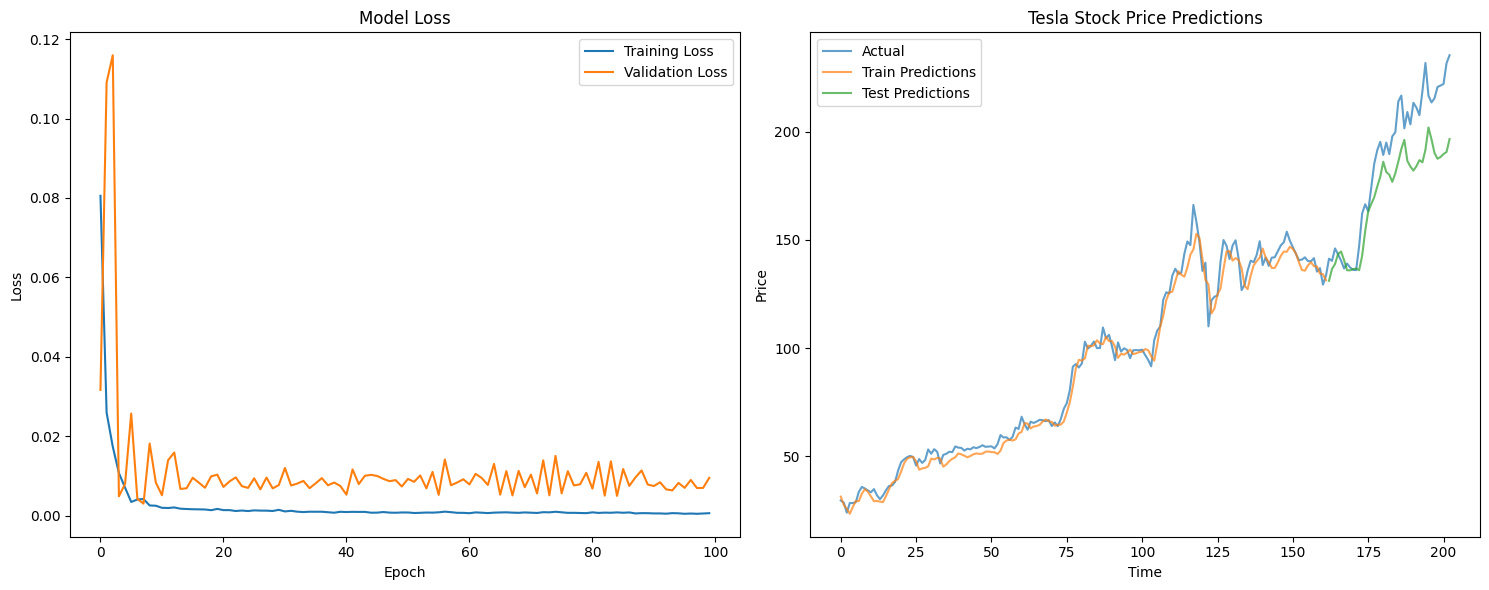

In [14]:
def main():
    sequence_length = 50
    input_size = 29
    hidden_size = 128
    num_layers = 2 
    num_epochs = 100 
    batch_size = 64
    learning_rate = 0.001
    train_split = 0.8
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    
    data = load_and_prepare_data()
    X, y, scaler, features = prepare_sequences(data, sequence_length)
    
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    train_dataset = StockDataset(X_train, y_train)
    test_dataset = StockDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    model = LSTM(input_size=29, hidden_size=256, num_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)
    
    predictions, actuals, metrics = evaluate_model(model, DataLoader(StockDataset(X, y), batch_size=batch_size), scaler, device, features)
    
    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    plot_results(train_losses, val_losses, predictions, actuals, train_size)

if __name__ == "__main__":
    main()